In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
pip install split-folders

  Using cached split_folders-0.5.1-py3-none-any.whl (8.4 kB)
Note: you may need to restart the kernel to use updated packages.


code is used to split the dataset. It can only be used once.

In [7]:
import splitfolders
splitfolders.ratio('BrainTumorDataset', output="output_dataset", seed=1337, ratio=(.7, 0.1,0.2)) 

Copying files: 2740 files [00:03, 873.91 files/s] 


# Generator 

use image data generator to gain more data for data augmentation store it in a new directory 'Augmented Image'

## 1. training data generator

In [12]:

IMG_SIZE=256
CHANNELS=3
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    rotation_range=10
)


train_generator=train_datagen.flow_from_directory(
    'output_dataset/train',
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=32,
    class_mode='sparse',
    save_to_dir="AugmentedImages"
)

Found 1916 images belonging to 4 classes.


determine the class labels

In [48]:
train_generator.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [49]:
class_names = list(train_generator.class_indices.keys())
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [14]:
for image_batch, label_batch in train_generator:
    print(image_batch[0])
    break

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


we can see that the image size has been rescaled properly

## 2. validation data generator

In [18]:
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True
)

validation_generator = validation_datagen.flow_from_directory(
    'output_dataset/val',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='sparse'
)

Found 272 images belonging to 4 classes.


## 3. test data generator

In [19]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
    'output_dataset/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='sparse'
)

Found 552 images belonging to 4 classes.


In [23]:
input_shape = (IMG_SIZE, IMG_SIZE, CHANNELS)
n_classes = 4 # because [0,3] means excluding 3, so take 4 units

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
1506/32

47.0625

how many batch size to run? 1 batch size is 32.We want to train with all the training images. 
therefore formula is Num_of_training_images/32


In [27]:
1916/32

59.875

validation has 272 images

In [28]:
272/32

8.5

so we have 59 steps per training

In [38]:
history = model.fit(
    train_generator,
    steps_per_epoch=59,
    batch_size=32,
    validation_data=validation_generator,
    validation_steps=6,
    verbose=1,
    epochs=20
)

Epoch 1/20
59/59 [==============================] - 135s 2s/step - loss: 0.0963 - accuracy: 0.9666 - val_loss: 0.2289 - val_accuracy: 0.9115
Epoch 2/20
59/59 [==============================] - 156s 3s/step - loss: 0.0822 - accuracy: 0.9713 - val_loss: 0.2332 - val_accuracy: 0.9427
Epoch 3/20
59/59 [==============================] - 151s 3s/step - loss: 0.0754 - accuracy: 0.9745 - val_loss: 0.2045 - val_accuracy: 0.9115
Epoch 4/20
59/59 [==============================] - 150s 3s/step - loss: 0.0700 - accuracy: 0.9719 - val_loss: 0.2368 - val_accuracy: 0.9583
Epoch 5/20
59/59 [==============================] - 163s 3s/step - loss: 0.0595 - accuracy: 0.9766 - val_loss: 0.2319 - val_accuracy: 0.9219
Epoch 6/20
59/59 [==============================] - 176s 3s/step - loss: 0.0629 - accuracy: 0.9777 - val_loss: 0.0953 - val_accuracy: 0.9635
Epoch 7/20
59/59 [==============================] - 190s 3s/step - loss: 0.0439 - accuracy: 0.9851 - val_loss: 0.2986 - val_accuracy: 0.9271
Epoch 8/20
59

# Test the model

In [39]:
scores = model.evaluate(test_generator)

18/18 [==============================] - 11s 618ms/step - loss: 0.3713 - accuracy: 0.9076


In [40]:
scores

[0.3712675869464874, 0.907608687877655]

## Plot the accuracy and loss curves

In [41]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

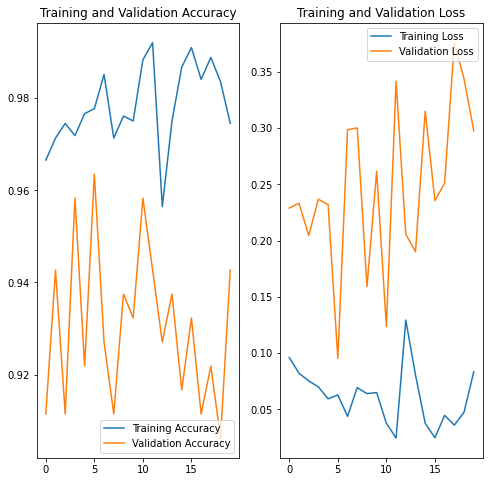

In [44]:
EPOCHS = 20

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## run a prediction on sample image

first image to predict
actual label: no_tumor
predicted label: no_tumor


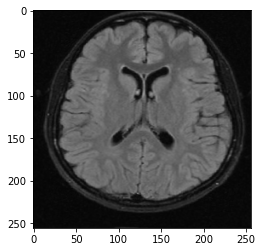

In [53]:
import numpy as np

for image_batch, label_batch in test_generator:
    first_image = image_batch[0]
    first_label = int(label_batch[0])
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    
    break

make an inference function

In [54]:
def predict(model, img):
    #convert image into array
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

run inference in a few sample image

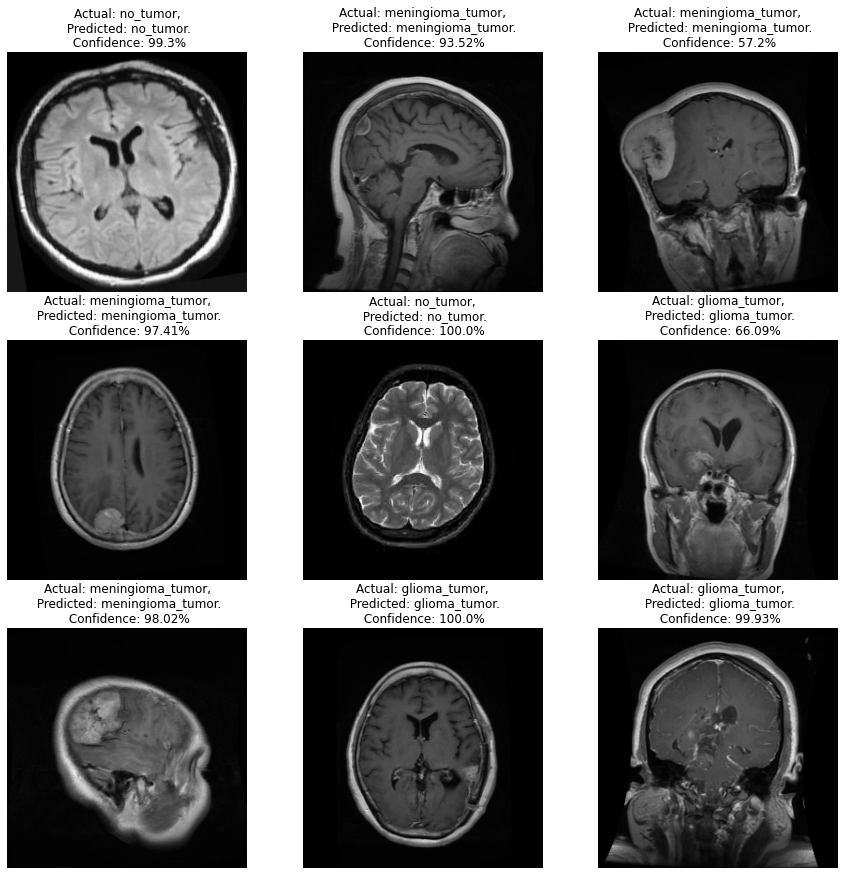

In [55]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

save the model in h5 format so it can be uploaded to gcp conveniently

In [56]:
model.save("../brains.h5")